# NLP - Detecção de Tweets de Desastres

Este notebook realiza uma classificação de tweets (texto livre) utilizando Processamento de Linguagem Natural (Natural Language Processing - NLP) na competição [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/). Esta competição tem como propósito identificar quais mensagens do Twitter, chamadas de tweets, são claramente avisos de um "desastre" - tento em vista que pessoas estão utilizando o Twitter para anunciar uma emergência que estão observando em tempo real. Sendo assim, agências buscam monitorar tweets a fim de identificar esses desastres e ativamente atender o chamado, antes mesmo de receber uma ligação direta.

> **Resumidamente**. Tarefa de classificação binária de texto, _i.e.,_ é um desastre ou não é.   
> Conteúdo voltado para nível intermediário da área de Aprendizado de Máquina e Ciência de Dados!

<a id="top"></a>
## Conteúdo

> **Nota**. Alguns códigos e outputs serão ocultados, a fim de facilitar a visualização dos dados e dar destaque para o conteúdo mais importante.

O notebook está organizado como segue:

- [Dados](#data) - Tratamendo dos dados.
  - Pré-processamento do texto
- [Vetorização](#feature)
  - Utilizando BOW 
- [Classificação](#classification) dos tweets.
  - [Regressão Logística](#reg) - Classificação com Regressão Logística.
  - [Explainability](#exp) - Simples visualização da importância das palavras.

-----
<a id="data"></a>
# Dados

- Importando as bibliotécas
- Carregamento dos dados
- Pré-processamento dos dados

[Voltar para o Topo](#top)

## Importando as Bibliotécas

In [1]:
# data processing, linear algebra
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt

## Carregando os Dados

In [2]:
# imprime os arquivos
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test  = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print('Treino - linhas: %d colunas: %d' % df_train.shape)
print('Teste  - linhas: %d colunas: %d' % df_test.shape)

Treino - linhas: 7613 colunas: 5
Teste  - linhas: 3263 colunas: 4


Tuplas de exemplo.

In [4]:
df_train.sample(3)

,id,keyword,location,text,target
6611,9467,terrorism,NaN,Pakistan's Supreme Court rules to allow milita...,1
545,794,avalanche,NaN,Chevrolet : Avalanche LT 2011 lt used 5.3 l v ...,1
5911,8441,sandstorm,USA,Watch This Airport Get Swallowed Up By A Sands...,1


Quais são as características dos nossos dados?

- Quantos valores nulos temos?

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## Pré-Processamento dos Dados

- Remove caracteres especiais - Links, @name, #hashtags.
- Transforma as palavras em tokens.
- Lematização - Reduz palavras para o lemma correspondente, de acordo com o significado no dicionário (análise vocabular e morfológica).
- Stemização - Reduz palavras flexionadas (ou às vezes derivadas) ao seu radical (stem).
- Vetorização dos dados - BOW, TFIDF

In [6]:
# natural language toolkit
import gensim
import nltk

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Lemmatization process
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


# Stemming process
def stemming(text):
    return stemmer.stem(text)


# Remove special characteres
def remove_special_char(text):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", text).split())


# Tokenization process
def preprocess(text):
    result = []
    new_text = remove_special_char(text)
    for token in gensim.utils.simple_preprocess(new_text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            LemmatizedToken = lemmatize(token)
            result.append(stemming(LemmatizedToken))
    return result

Seleciona um texto aleatório.

In [8]:
random_index = 956
random_text = df_train.iloc[random_index]['text']
print(random_text)

# handbags Genuine Mulberry Antony Cross Body Messenger Bag Dark Oak Soft Buffalo Leather:  å£279.00End Date: W... http://t.co/FTM4RKl8mN


Testando a remoção de caracteres especiais.

In [9]:
remove_special_char(random_text)

'handbags Genuine Mulberry Antony Cross Body Messenger Bag Dark Oak Soft Buffalo Leather 279 00End Date W'

Testa o pré-processamento do texto.

In [10]:
print(preprocess(random_text))

['handbag', 'genuin', 'mulberri', 'antoni', 'cross', 'bodi', 'messeng', 'dark', 'soft', 'buffalo', 'leather', 'date']


Executa o pré-processamento em toda base de treino.

In [11]:
df_train['text.process'] = df_train['text'].map(preprocess)
df_test['text.process']  = df_test['text'].map(preprocess)
display(df_train['text.process'])

0                           [deed, reason, allah, forgiv]
1                      [forest, near, rong, sask, canada]
2       [resid, ask, shelter, place, notifi, offic, ev...
3               [peopl, receiv, evacu, order, california]
4                [send, photo, rubi, smoke, pour, school]
                              ...                        
7608    [giant, crane, hold, bridg, collaps, nearbi, h...
7609    [ahrari, control, wild, fire, california, nort...
7610                                    [volcano, hawaii]
7611    [polic, investig, bike, collid, littl, portug,...
7612    [latest, home, raze, northern, california, wil...
Name: text.process, Length: 7613, dtype: object

-----
<a id="feature"></a>
# Vetorização

Vetorização consiste em transformar os texto em vetores, a fim de poder aplicar métodos de Aprendizado de Máquina.   
Neste estudo de caso, tilizaremos o BOW - melhor explicado a seguir.

> Visualização da importância das palavras será abordado após a classificação.


[Voltar para o Topo](#top)

## Bag of Words (BOW)

Bag-of-words (BOW) é uma representação simplificada usada no Processamento de Linguagem Natural (NLP). Consiste em considerar cada palavra como um atributo do documento, neste caso um tweet. Logo, cada tweet se torna um vetor com a contagem de vezes que a respectiva palavra (atributo do vetor) aparece no documento.

> **Nota**. Os vetores serão gigantestos, pois, usualmente, possuem muitas palavras unicas nos tweets.

In [12]:
# dense matrix
from gensim.matutils import corpus2dense

Busca as palavras unicas, chamados de tokens, do conjunto de dados de treinamento.

In [13]:
dictionary = gensim.corpora.Dictionary(df_train['text.process'])

Filtra os tokens que

- Aparecem em menos de 10 tweets (valor absoluto); or
- Mais de 75% dos tweets (fração de todos os tweets).
- Por fim, mantenha os 3,000 tokens mais frequentes.

In [14]:
keep_terms = 3_000
dictionary.filter_extremes(no_below=10, no_above=0.85, keep_n=keep_terms)

Constroí tuplas de _(palavra, contagem)_ para cada tweet.

In [15]:
bow_corpus      = [dictionary.doc2bow(doc) for doc in df_train['text.process'].tolist()]
bow_corpus_test = [dictionary.doc2bow(doc) for doc in df_test['text.process'].tolist()]

Verificando um dicionário BOW de um tweet aleatório.

In [16]:
display(bow_corpus[random_index])

[(167, 1), (294, 1), (399, 1), (451, 1), (457, 1), (741, 1)]

Criando as matrizes densos, isto é a construção de uma grande matriz com cada tweet e cada palavra dentro do dicionário.

In [17]:
id_test = df_test['id'].tolist()
X_dense      = corpus2dense(bow_corpus, num_terms=keep_terms, num_docs=df_train.shape[0]).T
X_dense_test = corpus2dense(bow_corpus_test, num_terms=keep_terms, num_docs=df_test.shape[0]).T

In [18]:
lin, col = X_dense.shape
print('linhas  -', lin)
print('colunas -', col)

linhas  - 7613
colunas - 3000


-----
<a id="classification"></a>
# Classificação

Nesta seção utilizamos a Regressão Logística como algoritmo de classificação.


[Voltar para o Topo](#top)

In [19]:
# training and test
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Conjunto de Treinamento e Validação

In [20]:
# return X_train, X_test, y_train, y_test from a dense_matrix
def get_x_y(dense_matrix, target):
    X = dense_matrix
    y = target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=26)
    return X_train, X_test, y_train, y_test

In [21]:
y_dense = df_train['target'].tolist()
X_train, X_test, y_train, y_test = get_x_y(X_dense, y_dense)

<a id="reg"></a>
## Regressão Logística

> Aumentar o número de iterações da Regressão não mudou o resultado.

In [22]:
# machine learning algorithm
from sklearn.linear_model import LogisticRegression

In [23]:
# trainning and test
def train_test(class_model, X_train, X_test, y_train, y_test):
    model = class_model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, accuracy_score(y_test, y_pred)

# print everything
def print_train_test(class_model, X_train, X_test, y_train, y_test):
    model, acc = train_test(class_model, X_train, X_test, y_train, y_test)
    display(model)
    display('score: %.4f' % acc)
    return model

In [24]:
%%time
# train, test model
class_model = LogisticRegression(random_state=26, max_iter=100)
model = print_train_test(class_model, X_train, X_test, y_train, y_test)

LogisticRegression(random_state=26)

'score: 0.7874'

CPU times: user 2.85 s, sys: 88.7 ms, total: 2.94 s
Wall time: 2.96 s


Treinando o modelo, utilizando todo o dataset de treinamento.

In [25]:
model = class_model.fit(X_dense, y_dense)

Gerando o arquivo de submissão da competição. _Função ocultada._

In [26]:
def gerenate_submission(model, X, id_test, file_name):
    target  = model.predict(X)
    submission = {'id':id_test, 'target':target}
    df_submission = pd.DataFrame(submission)
    df_submission.to_csv(file_name, index=False)

In [27]:
gerenate_submission(model, X_dense_test, id_test, 'submission.csv')

<a id="exp"></a>
## Explainability

Estudar qual a importância das features para o modelo.

Neste estudo explora-se:

- pacote `sklearn`, listando os pesos da Regressão Logística

In [28]:
# visualization
from matplotlib import pyplot

### Importância dos Atributos

Imprimir a importância de algumas palavras, bem como visualizar dos demais atributos.

In [29]:
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (dictionary.get(i),v))
    if i >= 10:
        break

Feature: reason, Score: 0.11529
Feature: canada, Score: 0.71021
Feature: forest, Score: 1.70087
Feature: near, Score: 1.10845
Feature: ask, Score: -0.55803
Feature: evacu, Score: 1.81385
Feature: expect, Score: 0.53518
Feature: offic, Score: 0.50711
Feature: order, Score: 0.43766
Feature: place, Score: -0.24343
Feature: california, Score: 1.90591


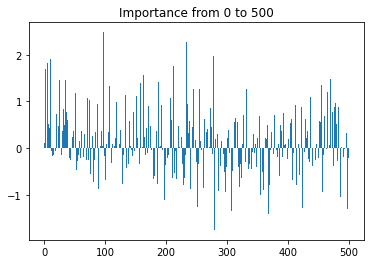

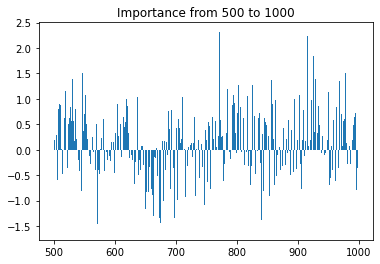

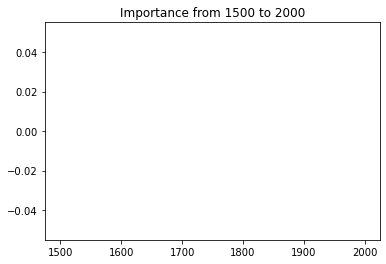

In [30]:
# plot feature importance
init_feature = 0
max_feature = 500

for i in range(3):
    pyplot.bar([x for x in range(init_feature, max_feature)], importance[init_feature:max_feature])
    pyplot.title('Importance from %d to %d' % (init_feature, max_feature))
    pyplot.show()
    init_feature += max_feature
    max_feature += max_feature

**Nota**. Aparentemente, após as primeiras 1500 palavras o modelo não extrai informações úteis dos documentos para a sua classificação.